## The ML Pipeline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/python code project

/content/drive/MyDrive/python code project


In [3]:
from gru_model import *
from lstm_model import *
from utils import *
from training import *

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

## Exploratory Data Analysis (EDA)

In [5]:
# Define data root directory
data_dir = "/content/drive/MyDrive/data"
print(os.listdir(data_dir))

['DAYTON_hourly.csv', 'DOM_hourly.csv', 'NI_hourly.csv', 'FE_hourly.csv', 'AEP_hourly.csv', 'DEOK_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'EKPC_hourly.csv', 'DUQ_hourly.csv', 'COMED_hourly.csv', 'PJM_Load_hourly.csv']


## Create training instances by moving sliding window

## Integrate files to build the training set
To speed things up, I will only be using `num_files_for_dataset` .csv files for creating my dataset. Feel free to run it yourself with the entire dataset if you have the time and computing capacity.

In [6]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(
    5
)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

test_x = {}
test_y = {}

# Specify the file to process
file_to_process = "DEOK_hourly.csv"  # Replace with your desired file name

print(f"Processing {file_to_process} ...")
# Store csv file in a Pandas DataFrame
df = pd.read_csv(os.path.join(data_dir, file_to_process), parse_dates=["Datetime"])

# Processing the time data into suitable input formats
df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
df = df.sort_values("Datetime").drop("Datetime", axis=1)

# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df.values)

# Obtaining the scaler for the labels (usage data) so that output can be
# re-scaled to actual value during evaluation
label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
label_scalers[file_to_process] = label_sc

# Move the window
inputs, labels = move_sliding_window(
    data,
    window_size,
    inputs_cols_indices=inputs_cols_indices,
    label_col_index=label_col_index,
)

# Use the entire file for testing
test_x[file_to_process] = inputs[:len(inputs)//4]
test_y[file_to_process] = labels[:len(inputs)//4]


Processing DEOK_hourly.csv ...
(57649, 90, 5) (57649, 1)


## What have we made?

In [7]:
test_x.keys()

dict_keys(['DEOK_hourly.csv'])

## Load the GRU model

In [8]:
device="cpu"

In [9]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers,device=device)
gru_model.load_state_dict(torch.load("/content/drive/MyDrive/models/gru_model.pt"))

<ipython-input-9-566a32448cf5>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gru_model.load_state_dict(torch.load("/content/drive/MyDrive/models/gru_model.pt"))


<All keys matched successfully>

In [10]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Load the LSTM model

In [11]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers,device=device)
lstm_model.load_state_dict(torch.load("/content/drive/MyDrive/models/lstm_model.pt"))

<ipython-input-11-9e0ab876b8f8>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load("/content/drive/MyDrive/models/lstm_model.pt"))


<All keys matched successfully>

In [12]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Model Evaluation

For the purpose of comparing the performance of both models as well, we'll being tracking the time it takes for the model to train and eventually comparing the final accuracy of both models on the test set. For our accuracy measure, we'll use ***Symmetric Mean Absolute Percentage Error (sMAPE)*** to evaluate the models. *sMAPE* is the sum of the **absolute difference** between the predicted and actual values divided by the average of the predicted and actual value, therefore giving a percentage measuring the amount of error.

This is the formula for *sMAPE*:

$sMAPE = \frac{100%}{n} \sum_{t=1}^n \frac{|F_t - A_t|}{(|F_t + A_t|)/2}$

## Evaluate performance of GRU

In [13]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers,device=device)

Evaluation Time: 30.598266533
sMAPE: 0.325%


## Evaluate performance of LSTM

In [14]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers,device=device)

Evaluation Time: 29.960432662000002
sMAPE: 0.301%


While the GRU model may have made smaller errors and edged the LSTM model slightly in terms of performance accuracy, the difference is insignificant and thus inconclusive. There have been many other tests conducted by others comparing both these models but there has largely been no clear winner as to which is the better architecture overall.

In [15]:
len(
    gru_outputs
)  # list of predicted output file for each state (each element has a 1d array for that state)

1

# Some visualizations

Lastly, let's do some visualizations on random sets of our predicted output vs the actual consumption data for some states.

In [16]:
states_list = list(test_x.keys())

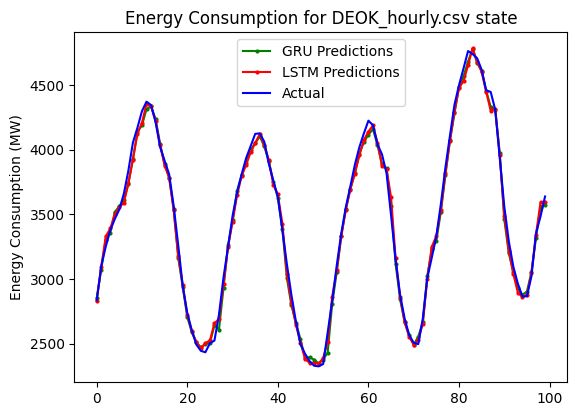

In [18]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(
    lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2
)
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()
